# Notebook for visualising manuscript embeddings

Load manuscript images

In [11]:
import numpy as np
import torch
from torchvision import datasets, transforms

image_size = 500

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size-1),
                                transforms.ToTensor()])
manuscript_dataset = datasets.ImageFolder('../data/images/', transform=transform)
manuscript_label_to_name =  {value:key for key, value in manuscript_dataset.class_to_idx.items()}

manuscript_dataloader = torch.utils.data.DataLoader(manuscript_dataset, batch_size=128, shuffle=False)

image_batch, label_batch = next(iter(manuscript_dataloader))

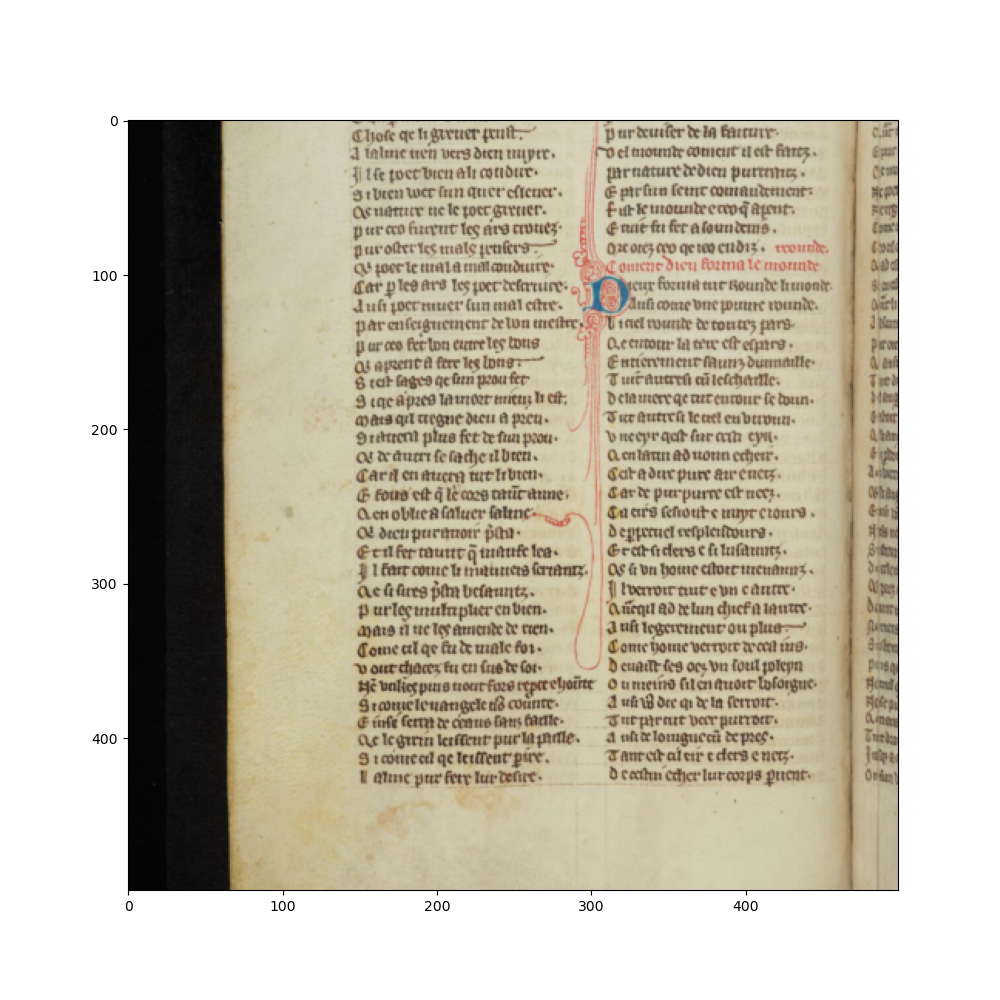

In [12]:
import matplotlib.pyplot as plt

def plot_image(image_tensor, gray=True):
    if isinstance(image_tensor, torch.Tensor):
        image_tmp = image_tensor.clone()
        image_tmp = image_tmp.numpy()
        image_tmp=np.swapaxes(image_tmp,0,1)
        image_tmp=np.swapaxes(image_tmp,1,2)
        
    elif isinstance(image_tensor, np.ndarray):
        image_tmp = image_tensor.copy()
    fig = plt.figure(figsize=(10,10))
    if gray:
        plt.imshow(image_tmp, cmap='gray')
    else:
        plt.imshow(image_tmp)
    plt.show()
plot_image(image_batch[0])


Load pre-calculated manuscript vectors

In [13]:
manuscript_vectors = np.load('numpy/vectors.npy')
manuscript_labels = np.load('numpy/labels.npy')

## Data formatting and plotting

Make a dataframe - group the rows by manuscript

In [14]:
import pandas as  pd

manuscript_dataframe = pd.DataFrame({'vector': [x for x in manuscript_vectors], 'label': manuscript_labels})
manuscript_dataframe['manuscript'] = [manuscript_label_to_name[label] for label in manuscript_dataframe['label']]
manuscript_groups = manuscript_dataframe.groupby(by='manuscript')

manuscript_groups.groups

{'astro-christ': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 'astro-chronicle_nurem': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], 'astro-islam': [34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], 'natural-history': [51], 'natural-poetry': [52]}

## Visualisation

In [15]:
from sklearn.decomposition import PCA

In [16]:
from matplotlib import gridspec

In [17]:
# Colourblind colourschemes
from colour_schemes import tol_cset
from matplotlib import colors
colours = list(tol_cset("bright"))
cmap = colors.ListedColormap(colours[:-2])

In [18]:
%matplotlib widget

In [19]:
pca2 = PCA()
transformed = pca2.fit_transform(manuscript_vectors).T
x,y = transformed[0],transformed[2]

12

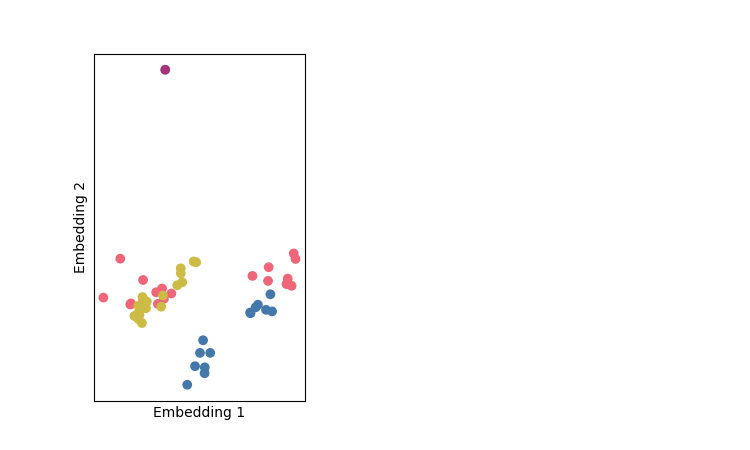

In [20]:
# Figure
gs = gridspec.GridSpec(1,2,width_ratios=[2,3])
fig = plt.figure(figsize=(7.5,4.5))
lax = plt.subplot(gs[0])
rax = plt.subplot(gs[1])
# Scatter plot for LHS
scatter = lax.scatter(x,y,c=manuscript_labels,cmap=cmap)
# Make it look nicer
lax.set_xlabel("Embedding 1")
lax.set_ylabel("Embedding 2")
lax.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

img = rax.imshow(image_batch[0].permute(1, 2, 0))
rax.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
rax.set_visible(False)
def hover(event):
    # if the mouse is over the scatter points
    if scatter.contains(event)[0]:
        # find out the index within the array from the event
        ind, = scatter.contains(event)[1]["ind"]
        # Show view and make it visible
        img.set_data(image_batch[ind].permute(1, 2, 0))
        rax.set_visible(True)
    else:
        #if the mouse is not over a scatter point
        rax.set_visible(False)
    fig.canvas.draw_idle()
# add callback for mouse moves
fig.canvas.mpl_connect('motion_notify_event', hover)    